In [1]:
import pickle
import string
import itertools
import scipy

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

%matplotlib inline

In [2]:
r_state = 8

In [35]:
with open("authors.pkl", 'r') as out_auths:
    authors = pickle.load(out_auths)
with open("labels.pkl", 'r') as las:
    author_labels = pickle.load(las)
print author_labels

[(1, 'Paul Lewis'), (2, 'Dan Roberts'), (3, 'Jeb Lund'), (4, 'Tom McCarthy'), (5, 'Ben Jacobs'), (6, 'Sabrina Siddiqui')]


In [3]:
with open("auth_sents.pkl", 'r') as ins:
    sents = pickle.load(ins)
    
print sents["Paul Lewis"][0]

The diplomatic overture was dispatched to Hu Yaobang, chairman of the Chinese Communist party, on 29 October 1981.


In [4]:
#Sentence features
#Sentence length, avg word length, abs(log(punc_freq)), abs(log(stopword_freq))
with open("features.pkl", 'r') as outs:
    features = pickle.load(outs)
print features[0]
print len(features)

with open("raw_features.pkl", 'r') as rfouts:
    rf_counts = pickle.load(rfouts)
print rf_counts[0]

[21, 4.619047619047619, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.8815637979434374, 0.0, 4.574710978503383, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.574710978503383, 0.0, 4.574710978503383, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.8815637979434374, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.574710978503383, 0.0, 0.0, 0.0, 0.0, 0.0, 4.574710978503383, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3580
[('len_s', 21), ('len_w', 4.619047619047619), (u'!'

In [5]:
sp = string.punctuation
sp = unicode(sp)
punct = [s for s in sp]

#punct = [u'!', u'$', u'%', u'?', u':', u';', u'``', u"''", u'\u2013']
punct.append(u'``')
punct.append(u"''")
punct.append(u'\u2013')
print punct, len(punct)

[u'!', u'"', u'#', u'$', u'%', u'&', u"'", u'(', u')', u'*', u'+', u',', u'-', u'.', u'/', u':', u';', u'<', u'=', u'>', u'?', u'@', u'[', u'\\', u']', u'^', u'_', u'`', u'{', u'|', u'}', u'~', u'``', u"''", u'\u2013'] 35


In [6]:
swords = stopwords.words('english')
swords.append('\'s')
swords.append('\'t')
print swords, len(swords)

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [7]:
raw_features = ["num_words", "w_len"] + punct + swords
print raw_features

['num_words', 'w_len', u'!', u'"', u'#', u'$', u'%', u'&', u"'", u'(', u')', u'*', u'+', u',', u'-', u'.', u'/', u':', u';', u'<', u'=', u'>', u'?', u'@', u'[', u'\\', u']', u'^', u'_', u'`', u'{', u'|', u'}', u'~', u'``', u"''", u'\u2013', u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', 

In [8]:
main_fs = [0, 16, 1, 14, 130, 142, 107, 39, 48, 91, 9, 31, 129, 109, 37, 73, 93, 80]  
for f in main_fs:
    print f, " ", raw_features[f]


0   num_words
16   /
1   w_len
14   -
130   here
142   most
107   against
39   my
48   yourself
91   an
9   (
31   |
129   once
109   into
37   i
73   those
93   and
80   been


In [9]:
#flat_features = list(itertools.chain.from_iterable(features))
#print flat_features[0]
#print len(flat_features)

In [10]:
combined_sents = []

for author, sentences in sents.iteritems():
    for sentence in sentences:
        combined_sents.append(sentence)

print combined_sents[0]

The diplomatic overture was dispatched to Hu Yaobang, chairman of the Chinese Communist party, on 29 October 1981.


In [11]:
for cs in combined_sents:
    if u"/" in cs:
        print cs

When Paul accused Christie in turn of getting too close to the White House and “hugging” Obama, the New Jersey governor shot back that the hugs he remembered were with the families of 9/11 victims.
“The terrorists are possessed by the same violent ideology that gave us 9/11, and they are on the offensive and gaining ground,” Jeb Bush will say.
The former prime minister also talked about the lessons of the post-9/11 era.
Just as soon as you had finished formulating a single thought about one person in a blue/black worsted wool suit with a blue/red tie, a new one (or Carly Fiorina) had taken his place.
The Donald, on the other hand, will try to increase his negotiating leverage with NBC by pointing to all the people who tune in to see him “tell it like it” is on a fake show and will probably try to sell a few more seats in his scam college, assuming the whole thing isn’t in a joint FBI/SEC warehouse by now.
After flirting with it early in his tenure, Kasich has backed away from what you 

### NLP / Clustering Challenges


##### Challenge 1

Cluster sentences with K-means. If you have your own Fletcher text data, get sentences out and cluster them. If not, cluster the tweets you gathered during the last challenge set. For each cluster, print out the sentences, try to see how close the sentences are. Try different K values and try to find a K value that makes the most sense (the sentences look like they do form a meaningful cluster).

How do you deal with retweets (if you're clustering tweets)?

In [12]:
def run_k_means(X, k, vectorized=False, vectizer=None):
    model = KMeans(n_clusters=k, max_iter=100, random_state=r_state) #init='k-means++'
    model.fit(X)
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    if vectorized:
        terms = vectizer.get_feature_names()
    else:
        terms = raw_features
        #print order_centroids
    for i in range(len(model.cluster_centers_)):
        print "Cluster %d:" % i,
        for ind in order_centroids[i, :10]:
            if vectorized:
                #print ind, 
                print ' %s' % terms[ind],
            else:
                print terms[ind], 
                #f_ind = features.index(ind)
                #print f_ind
                #print ' %s' % terms
        print
    return model

def vectorizer_k_means(sentence, k):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(sentence)
    model = run_k_means(X, k, vectorized=True, vectizer=vectorizer)
    return model

In [13]:
#Cluster of terms per author

k_ = 4 #4, 5, 6

for author, sent in sents.iteritems():
    print author
    author_model = vectorizer_k_means(sent, k_)

Paul Lewis
Top terms per cluster:
Cluster 0:  hsbc  bank  swiss  irs  ex  tax  leaked  data  im  clients
Cluster 1:  sanders  senator  house  republican  party  republicans  campaign  young  political  candidate
Cluster 2:  said  deal  president  don  does  world  iran  senator  race  obama
Cluster 3:  candidates  policy  debate  fox  news  trump  republican  presidential  stage  foreign
Dan Roberts
Top terms per cluster:
Cluster 0:  house  said  white  know  new  paul  governor  policy  told  obama
Cluster 1:  immigration  reform  campaign  gardner  colorado  republican  udall  party  rights  local
Cluster 2:  party  senate  mcconnell  tea  republican  candidates  republicans  democrats  primary  house
Cluster 3:  clinton  bush  president  iraq  state  secretary  hillary  said  campaign  senator
Jeb Lund
Top terms per cluster:
Cluster 0:  people  good  don  said  florida  things  republican  candidate  great  policy
Cluster 1:  like  just  donald  trump  republican  party  doesn  mean

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [14]:
k1 = 8
print "All authors"
all_model = vectorizer_k_means(combined_sents, k1)

All authors
Top terms per cluster:
Cluster 0:  governor  walker  wisconsin  state  scott  bush  florida  republican  jeb  budget
Cluster 1:  policy  obama  people  rubio  time  president  like  american  candidates  iran
Cluster 2:  said  people  don  president  rubio  think  paul  walker  like  policy
Cluster 3:  trump  donald  debate  said  republican  candidates  immigration  party  comments  way
Cluster 4:  clinton  hillary  secretary  state  policy  campaign  obama  foreign  republican  democratic
Cluster 5:  senator  cruz  ted  rubio  paul  marco  florida  rand  texas  kentucky
Cluster 6:  republican  house  party  senate  white  republicans  democrats  immigration  obama  reform
Cluster 7:  hsbc  bank  swiss  im  ex  irs  leaked  accounts  doj  clients


In [15]:
k2 = 4
print "Sentence features"
feature_model = run_k_means(features, k2)

##These results look weird, but it could be because it is the frequency of each of these aspects that is being 
## fed to the clustering algorithm, not the name of the aspect itself

Sentence features
Top terms per cluster:
Cluster 0: num_words / w_len - here most against my an yourself
Cluster 1: num_words w_len / here - most my | against an
Cluster 2: num_words / w_len - here most my against an yourself
Cluster 3: num_words / most ( - | w_len here yourself my


##### Challenge 2

Draw the inertia curve over different k values. (The sklearn KMeans class has an inertia_ attribute.)

In [16]:
ks = range(2,26)
inertiadict = {}
for author, sent in sents.iteritems():
    print "\n", author
    inertiadict[author] = []
    for k in ks:
        print k,
        vectorizer2 = TfidfVectorizer(stop_words='english')
        X = vectorizer2.fit_transform(sent)
        model = KMeans(n_clusters=k, max_iter=100, random_state=r_state) #init='k-means++'
        model.fit(X)
        inertiadict[author].append(model.inertia_)
    


Paul Lewis
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
Dan Roberts
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
Jeb Lund
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
Tom McCarthy
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
Ben Jacobs
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
Sabrina Siddiqui
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25


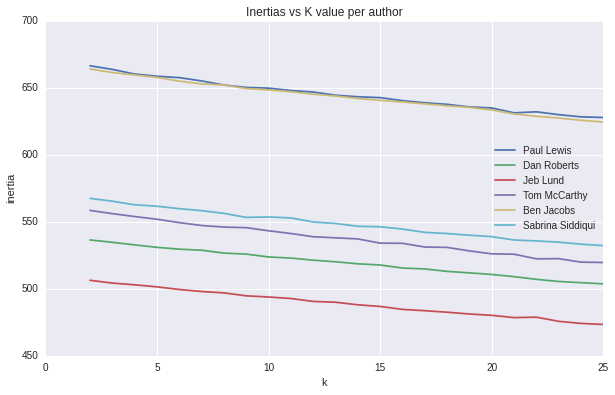

In [17]:
plt.figure(figsize=(10,6))
for author, sent in sents.iteritems():
    plt.plot(ks, inertiadict[author], label=author)
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("Inertias vs K value per author")
plt.legend(loc="best")
plt.show()

In [18]:
ks = range(2,16)
inertias = []
for k in ks:
    print k,
    vectorizer2 = TfidfVectorizer(stop_words='english')
    X = vectorizer2.fit_transform(combined_sents)
    model = KMeans(n_clusters=k, max_iter=100, random_state=r_state) #init='k-means++'
    model.fit(X)
    inertias.append(model.inertia_)
    

2 3 4 5 6 7 8 9 10 11 12 13 14 15


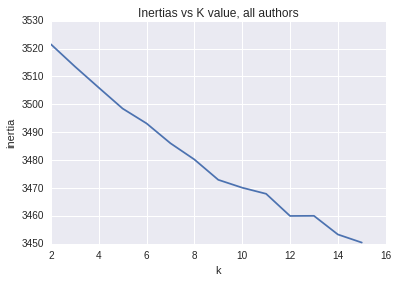

In [19]:
ax = plt.subplot(111)
plt.plot(ks, inertias)
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("Inertias vs K value, all authors")
plt.show()

In [20]:
fks = range(2,16)
f_inertias = []
for k in fks:
    print k,
    model = KMeans(n_clusters=k, max_iter=100, random_state=r_state) #init='k-means++'
    model.fit(features)
    f_inertias.append(model.inertia_)

2 3 4 5 6 7 8 9 10 11 12 13 14 15


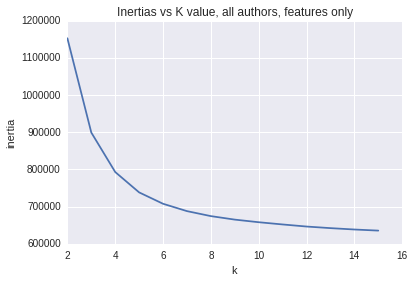

In [21]:
ax = plt.subplot(111)
plt.plot(fks, f_inertias)
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("Inertias vs K value, all authors, features only")
plt.show()

##### Challenge 3

__Let's name the clusters 1__

For each cluster, find the sentence closest to the centroid of the cluster.

(You can use [sklearn.metrics.pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) or [scipy.spatial.distance](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html) [check `pdist`, `cdist`, and `euclidean distance`] to find distances to the centroid). KMeans has a cluster_centroids_ attribute.

This sentence (closest to centroid) is now the name of the cluster. For each cluster, print the representative sentence, and print 'N people expressed a similar statement', or something like that relevant to your dataset. (This is very close to what amazon used to do in the reviews section.)

Find the biggest 3 clusters, and print their representative sentences. (This is close to what amazon is doing now in the reviews section, except they choose the sentence from the most helpful review instead of closest to center.)


In [22]:
cluster_numbers_f = feature_model.predict(features)
print cluster_numbers_f[:10]

[1 2 2 2 3 1 1 2 1 1]


In [23]:
f_centroids = feature_model.cluster_centers_
print f_centroids.shape

(4, 166)


In [24]:
c_labels_f = range(f_centroids.shape[0])
clusters_dict_f = {el:[] for el in c_labels_f}
#print clusters_dict_all
count = 0
for i, cna in enumerate(cluster_numbers_f):
    clusters_dict_f[cna].append(i)

print clusters_dict_f[len(c_labels_f)-1]


[4, 104, 116, 179, 286, 291, 342, 348, 358, 366, 387, 388, 442, 446, 463, 490, 542, 551, 669, 725, 754, 764, 767, 768, 771, 784, 788, 849, 857, 871, 874, 922, 945, 947, 955, 968, 976, 987, 995, 1004, 1012, 1037, 1059, 1071, 1076, 1078, 1108, 1114, 1129, 1148, 1153, 1154, 1155, 1173, 1186, 1191, 1276, 1284, 1303, 1315, 1316, 1336, 1350, 1355, 1376, 1380, 1383, 1413, 1438, 1443, 1461, 1462, 1524, 1546, 1569, 1571, 1583, 1613, 1617, 1622, 1628, 1632, 1664, 1672, 1677, 1687, 1691, 1693, 1694, 1695, 1723, 1726, 1730, 1833, 1849, 1898, 1913, 1972, 1995, 2040, 2049, 2053, 2060, 2067, 2068, 2177, 2212, 2214, 2217, 2229, 2249, 2286, 2334, 2376, 2406, 2438, 2483, 2484, 2515, 2532, 2569, 2606, 2632, 2684, 2685, 2741, 2774, 2799, 2817, 2821, 2838, 2879, 2880, 2891, 2946, 2965, 2981, 2983, 3066, 3082, 3089, 3109, 3116, 3120, 3132, 3136, 3138, 3141, 3290, 3329, 3337, 3372, 3381, 3407, 3422, 3432, 3436, 3468, 3484, 3493, 3496, 3502, 3508, 3522, 3535, 3544, 3564]


In [41]:
mins = []
for lab, inds in clusters_dict_f.iteritems():
    xs = []
    print lab
    #print inds
    mindist = (9999999,9999,9999, len(inds))
    for ind in inds:
        #print ind
        xs.append(features[ind])
        
        dist = scipy.spatial.distance.euclidean(features[ind], f_centroids[lab])
        if dist < mindist[0]:
            mindist = (dist, lab, ind, len(inds))
    mins.append(mindist)
print mins

 0
1
2
3
[(11.496098183909673, 0, 811, 757), (5.3791913601555112, 1, 2041, 1219), (7.8134461773278892, 2, 2810, 1437), (16.834422010698255, 3, 2817, 167)]


In [42]:
for m in mins:
    print "cluster:", m[1]
    print sorted(rf_counts[m[2]], key=lambda x:(-x[1],x[0]))[:20], "author number", authors[m[2]], \
                    "and", m[3], "similar sentences"

cluster: 0
[('len_s', 47), (u',', 7), ('len_w', 4.446808510638298), (u'and', 3), (u'in', 3), (u'the', 3), (u'.', 1), (u'a', 1), (u'for', 1), (u'of', 1), (u'off', 1), (u'!', 0), (u'"', 0), (u'#', 0), (u'$', 0), (u'%', 0), (u'&', 0), (u"'", 0), (u"''", 0), ("'s", 0)] author number 2 and 757 similar sentences
cluster: 1
[('len_s', 12), ('len_w', 3.0), (u"''", 2), (u'.', 2), (u'``', 2), (u',', 1), (u'!', 0), (u'"', 0), (u'#', 0), (u'$', 0), (u'%', 0), (u'&', 0), (u"'", 0), ("'s", 0), ("'t", 0), (u'(', 0), (u')', 0), (u'*', 0), (u'+', 0), (u'-', 0)] author number 4 and 1219 similar sentences
cluster: 2
[('len_s', 30), ('len_w', 4.5), (u',', 2), (u'his', 2), (u'in', 2), (u'of', 2), (u'the', 2), (u'.', 1), (u'and', 1), (u'to', 1), (u'!', 0), (u'"', 0), (u'#', 0), (u'$', 0), (u'%', 0), (u'&', 0), (u"'", 0), (u"''", 0), ("'s", 0), ("'t", 0)] author number 5 and 1437 similar sentences
cluster: 3
[('len_s', 82), (u'the', 7), (u'on', 4), ('len_w', 3.817073170731707), (u'to', 3), (u'was', 3), ("'s"

##### Challenge 4

__Let's name the clusters 2__

Calculate the tf-idf of each word in each cluster (think of all sentences of a cluster together as a document). Represent each cluster with the top 1, or top 2 or... to 5 tf-idf words. For each cluster, print the name (keywords) of the cluster, and "N statements" in the cluster (N is the size of the cluster)



##### Challenge 5

__Let's name the clusters 3__

Same as the previous challenge, but this time, calculate tf-idf only for nouns (NN tag) and build keyword(s) with nouns. (This is close to what amazon switched to last year, before settling into the current design). (They would show five nouns, you would click on one and it would show sentences - linked to the reviews- that were related to that noun.)


##### Challenge 6

Cluster the same data with [MiniBatchKMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html). MiniBatchKMeans is a fast way to apply K-means to large data without much loss -- The results are very similar. Instead of using EVERY single point to find the new place of the centroid, MiniBatch just randomly samples a small number (like 100) in the cluster to calculate the new center. Since this is usually very close to the actual center, the algorithm gets there much faster. Try it and compare the results. ([Example on two-feature data](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html))



##### Challenge 7

Switch the __init__ parameter to "random" (instead of the default kmeans++) and plot the inertia curve for each of the __n_init__ values for K-Means: 1, 2, 3, 10 (n_init is the number of different runs to try with different random initializations).



##### Challenge 8

Download [this dataset on the purchase stats from clients of a wholesale distributor](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). Cluster the clients based on their annual spending features (fresh, milk, grocery, frozen, detergents_paper, delicatessen). Remember to scale the features before clustering. After finding a reasonable amount of clusters, for EACH cluster, plot the histogram for every single feature: FRESH, MILK, GROCERY, FROZEN, DETERGENTS_PAPER, DELICATESSEN, CHANNEL, REGION. Is there a natural way to characterize each cluster? How would you describe each cluster to the wholesale distributor if you were working for them?



#### Clustering Extensions (Optional)

Use the same code for your previous clustering challenges.

Repeat each challenge (except the inertia curves, since only the KMeans implementation gives a quick way of calculating that.) However, this time, try (both) Agglomerative Clustering and DBSCAN instead of KMeans.

For text clustering, use cosine distance.